# Compare UNet deconv. quality wrt Tikhonov and in 2-models scenario
v>=26dec25

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.lines as lines
mpl.rcParams["font.size"] = 16
mpl.rcParams['axes.titlesize'] = 16
plt.rcParams['image.cmap'] = 'RdBu_r'

In [4]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('../code')) # path to your source code
sys.path.insert(0, module_path)

In [5]:
from types import SimpleNamespace
import multiprocessing
import time
import regex as re
import glob
import json
import yaml
import random

import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F
from torch.fft import fft2, ifft2, fftshift, ifftshift

import galsim
from model import *
from galaxy_img_utils import *

#for Wiener decon
from deconv_wiener import *

In [6]:
from utils_plot import *

In [7]:
import pandas as pd

In [8]:
from skimage.metrics import structural_similarity as ssim
from scipy.optimize import minimize_scalar

# You can regenerate the Pandas DF and other outpu files or directly jump to the ploting section using the provided files. 

# Use trained models on validatiuon images

In [7]:
config_file = "./config_DeconvNoisy_COSMOS_4nb.yaml"


with open(config_file, "r") as config:
    settings_dict = yaml.safe_load(config)
args = SimpleNamespace(**settings_dict)

In [8]:
args

namespace(fov_pixels=48,
          pixel_scale=0.03,
          upsample=4,
          atmos_fwhm=0.4,
          atmos_e=0.01,
          sigma_defocus=0.1,
          sigma_opt_psf=0.07,
          min_shear=0.01,
          max_shear=0.05,
          opt_obs_min=0.1,
          opt_obs_width=0.4,
          lam_ov_d_min=0.017,
          lam_ov_d_width=0.007,
          sigma_noise_max=1.0,
          archi='Unet-Full',
          pool_window=2,
          num_blocks=2,
          num_kernels=64,
          num_channels=1,
          kernel_size=3,
          padding=1,
          bias=True,
          num_enc_conv=2,
          num_mid_conv=2,
          num_dec_conv=2,
          input_cosmos_dir='/lustre/fsn1/projects/rech/ixh/ufd72rp/',
          input_data_dir='../',
          input_gal_file_list='list_gal_files_48pix.json',
          models_root_dir='../models/',
          seed=116122025,
          num_workers=10,
          checkpoint_file='/Unet-Full_last_state.pth',
          history_loss_cpt_file=

In [9]:
#for this nb the tag is defined as
#atmos_fwhm = 0.4
#args.run_tag = "Unet_cosmo_atm0d4_sigma1d0"
atmos_fwhm = 0.8
args.run_tag = "Unet_cosmo_atm0d8_sigma1d0"

In [10]:
# see generator function for noise generation
args.PSNR_max = 40.0 # sigma = 0.01
args.PSNR_min = 0.445 # sigma = 0.95

In [11]:
# device cpu/gpu...
args.device = (
    torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
)

In [12]:
#soverlaod the default function to sample in PSHR input the noise
class GalaxyDataset(Dataset):

    def __init__(
        self,
        settings,
        all_gal,
        all_psf,
        all_noise,
        all_info,
        sequence,
        debug=False
    ):
        """
        settings: run settings
        all_gal: list of galaxy FITS files
        all_psf: list of HST PSF files
        all_noise: list of noise files 
        all_info: list of additional information files        
        sequence: indexes of galaxies in the dataset
        """
        self.debug = debug
        self.settings = settings
        #
        self.all_gal   = all_gal
        self.all_psf   = all_psf
        self.all_noise = all_noise
        self.all_info  = all_info
        #
        n_gal = len(self.all_gal)
        self.seq = sequence
        
        assert n_gal >= len(self.seq), "pb n_gal < sequence length" 
        
        print("GalaxyDataset: size",len(self.seq),' among ',n_gal,'galaxies')

    def __len__(self):
        return len(self.seq)

    def __getitem__(self, idx):
        """
        Build ground truth and observation from HST galaxy
        idx : index < len(self.seq)
        """
        
        i = self.seq[idx]

        # Read out real galaxy from the catalog and the correspondig HST PSF
        gal_orig = galsim.fits.read(self.all_gal[i]) # original galaxy image
        psf      = galsim.fits.read(self.all_psf[i]) # original HST PSF
        noise    = galsim.fits.read(self.all_noise[i]) # original noise image
        with open(self.all_info[i], "r") as f:
            info = json.load(f)
            pixel_scale = info["pixel_scale"]  # original pixel_scale
            var = info['var']                  # original noise variance

        #print("GalaxyDataset gal_orig",gal_orig.array.min(),gal_orig.array.max(),gal_orig.array.sum())
        # Genetare a couple of ground truth and obersation with new PSF and snr
        psf.array = psf.array/psf.array.sum() # adjust flux to 1.0 for HST PSF
        psf_hst   = galsim.InterpolatedImage(psf)
        gal_rg    = galsim.RealGalaxy((gal_orig,psf,noise,pixel_scale,var))

        if self.debug:
             gt, obs, gt_full, conv, psf_obs, sigma = generator(self.settings, gal_rg, psf_hst, debug=True)
        else:
            gt, obs = generator(self.settings, gal_rg, psf_hst, debug=False)        
        
        # transform to CHW with C=1
        gt  = gt.unsqueeze(0)
        obs = obs.unsqueeze(0)

        if self.debug:
            return  gt, obs, gt_full, conv, psf_obs, sigma
        else:
            return gt, obs

def generator(args, gal_orig, psf_hst, debug=False):
    """
    args: settings
    gal_orig: original Real Galaxy extracted from catalog
    psf_hst: HST PSF associated to gal_orig
    """
    psf_obs,_ = gener_PSF_obs(args)
    
    # Galaxy parameters .
    gal_g = args.rng_gal_shear() # Shear of the galaxy (magnitude of the shear in the "reduced shear" definition), U(0.01, 0.05).
    gal_beta = 2.0 * np.pi * args.rng()  # Shear position angle (radians), N(0,2*pi).
    gal_mu = 1.0 + args.rng() * 0.1  # Magnification, U(1.,1.1).
    theta = np.pi/2. * np.floor(4*args.rng()) #  Rotation angle (radians), 0,pi/2,pi,3/2pi
    dx = 2 * args.rng() - 1  # Offset along x axis, U(-1,1).
    dy = 2 * args.rng() - 1  # Offset along y axis, U(-1,1).
        
    gt = get_Galaxy_img(
        gal_orig,
        psf_hst,
        gal_g=gal_g,
        gal_beta=gal_beta,
        theta=theta,
        gal_mu=gal_mu,
        dx=dx,
        dy=dy,
        fov_pixels=args.fov_pixels,
        pixel_scale=args.pixel_scale,
        upsample=args.upsample,
    )

    # Convolution with the new PSF
    conv = ifftshift(ifft2(fft2(psf_obs.clone()) * fft2(gt.clone()))).real  

    # Downsample images to desired pixel scale.
    # avoid conv, psf down_scaling as there are only intermediate steps useful for debug
    gt_full = gt.clone()
    gt  = down_sample(gt_full, args.upsample)
    conv = down_sample(conv.clone(), args.upsample)

    # Add noise
    psnr_in  = args.PSNR_min + (args.PSNR_max - args.PSNR_min) * args.rng()
    sigma = 10**(-psnr_in/20.)
    ####sigma =args.sigma_noise_max * args.rng()  # sigma of adittional noise, U(0;sigm_max) 
    obs = conv + torch.normal(
        mean=torch.zeros_like(conv), std=sigma * torch.ones_like(conv)
    )
    
    if debug:
        return gt, obs, gt_full, conv, psf_obs, sigma
    else:
        return gt, obs


In [13]:
# update settings for galaxy simulator (used in GalaxyDataset)
def reset_randoms(args):
    set_seed(args.seed)
    args.rng_base = galsim.BaseDeviate(seed=args.seed)
    args.rng = galsim.UniformDeviate(seed=args.seed)  # U(0,1).
    args.rng_defocus = galsim.GaussianDeviate(
    args.rng_base, mean=0.0, sigma=args.sigma_defocus)
    args.rng_gaussian = galsim.GaussianDeviate(
        args.rng_base, mean=0.0, sigma=args.sigma_opt_psf
    ) 
    args.rng_gal_shear = galsim.DistDeviate(
        seed=args.rng, function=lambda x: x, x_min=args.min_shear, x_max=args.max_shear
    )


In [14]:
if args.input_gal_file_list is not None:
    # in case the original COSMOS files have been filtered (eg. minimum pixel size required)
    fname = args.input_data_dir + args.input_gal_file_list
    try:
        with open(fname, "r") as f:
            info = json.load(f)
            all_gal = info["all_gal"]
            all_psf = info["all_psf"]
            all_noise = info["all_noise"]
            all_info = info["all_info"]
    except FileNotFoundError:
        print(f"The file {fname} was not found: look for location.")
    except IOError:
        print(f"An error occurred while reading the file {fname}.")
else:
    print("input_gal_file_list not set...")

In [15]:
# Update the data location
all_gal   = [args.input_cosmos_dir + x for x in all_gal]
all_psf   = [args.input_cosmos_dir + x for x in all_psf]
all_noise = [args.input_cosmos_dir + x for x in all_noise]
all_info  = [args.input_cosmos_dir + x for x in all_info]

In [16]:
n_total = len(all_gal)
print(n_total)
assert n_total == len(all_psf), "pb n_total neq n_psf"
assert n_total == len(all_noise), "pb n_total neq n_noise"
assert n_total == len(all_info), "pb n_total neq n_info"

53923


In [17]:
sequence = np.arange(0, n_total)
# sequence of validation images not seen by any models during their training
val_seq = sequence[-args.n_val:]  

In [18]:
import multiprocessing
NUM_CORES = multiprocessing.cpu_count()
if args.num_workers >= NUM_CORES:
    print("Info: # workers set to", NUM_CORES // 2)
    args.num_workers = NUM_CORES // 2


In [19]:
ds_val  = GalaxyDataset(args,
                             all_gal,
                             all_psf,
                             all_noise,
                             all_info,
                             val_seq,
                           debug=True)


val_loader = DataLoader(
        dataset=ds_val,
        batch_size=1,
        shuffle=False,
        pin_memory=True,
        num_workers=args.num_workers,
        drop_last=True,
)

GalaxyDataset: size 1000  among  53923 galaxies


## load models

In [30]:
# single mdoel Unet ("u") and Wiener-Tikhonov ("w")
df1 = pd.DataFrame(columns=["ntrain", "psnr_in", "psnr_u", "psnr_w", 
                            "ssim_in", "ssim_u", "ssim_w",
                            "cos_in", "cos_u", "cos_w"
                           ])
# normal & swapped model cosine similarirty
df2 = pd.DataFrame(columns=["ntrain", "cos"])
models = {}
models_swap = {}

In [31]:
def load_Unet(args,n_train,swap=False):
        
    model_tag = args.run_tag \
            + "_" + str(n_train) + "train" \
            + "_" + str(args.num_kernels) + "kernels" \
            + "_" + str(args.num_blocks) + "blocks" \
            + "_" + args.loss
    if swap:
        model_tag += "_swapped"

    model_dir = args.models_root_dir + "/" + model_tag + "/"
    print(">>> model_dir:",model_dir)
    model_checkpoint_file = model_dir + "Unet-Full_best_state.pth"
    model = UNet(args)
    model.to(args.device);
    checkpoint = torch.load(model_checkpoint_file)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model

In [32]:
def init_dataframe(args, models, models_swap):
    for i,n_train in enumerate(args.n_train):
        df1.loc[i] = {"ntrain": n_train, "psnr_in":[], "psnr_u":[], "psnr_w": [], 
                  "ssim_in":[], "ssim_u":[], "ssim_w":[],
                     "cos_in":[], "cos_u":[], "cos_w":[]}
        models[n_train]=load_Unet(args,n_train)
        if  n_train in args.n_swap:
            df2.loc[i] = {"ntrain": n_train, "cos":[]}
            models_swap[n_train]=load_Unet(args,n_train,swap=True)

In [33]:
df1

,ntrain,psnr_in,psnr_u,psnr_w,ssim_in,ssim_u,ssim_w,cos_in,cos_u,cos_w


In [34]:
df2

,ntrain,cos


In [35]:
def func(param,obs_img,psf_obs_img,upsample):
    image_deconv =  deconv_Wiener(obs_img[np.newaxis,np.newaxis,...],psf_obs_img[np.newaxis,...],
                              sampling_factor=upsample,
                                 balance=param)
    wiener_deconv_img =resize_conserve_flux(image_deconv.squeeze(),size=gt_img.shape).squeeze()
    return psnr(wiener_deconv_img,gt_img)

## Analysis: Loop over validation images

In [48]:
init_dataframe(args,models, models_swap)

>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_100train_64kernels_2blocks_MSE/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_100train_64kernels_2blocks_MSE_swapped/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_500train_64kernels_2blocks_MSE/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_500train_64kernels_2blocks_MSE_swapped/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_1000train_64kernels_2blocks_MSE/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_1000train_64kernels_2blocks_MSE_swapped/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_5000train_64kernels_2blocks_MSE/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_5000train_64kernels_2blocks_MSE_swapped/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_10000train_64kernels_2blocks_MSE/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_10000train_64kernels_2blocks_MSE_swapped/
>>> model_dir: ../models//Unet_cosmo_atm0d8_sigma1d0_20000train_64kernels_2blocks_MSE/
>>> model_dir: 

In [49]:
all_gt_imgs = torch.zeros(size=(len(val_loader),1,args.fov_pixels, args.fov_pixels))

In [33]:
# init randoms
reset_randoms(args)


# typical timing: 700 sec for 1000 validation images
for i_batch, imgs in enumerate(val_loader):
    gt, obs, gt_full, conv, psf_obs, sigma = imgs

    if i_batch%100 == 0 or i_batch == 0:
        print("start i_batch:",i_batch)
    #if i_batch>100: 
    #    break

    #store all gt images for cosine similarities
    all_gt_imgs[i_batch,0] = gt
    
    gt = gt.to(args.device)
    obs = obs.to(args.device)
    for ntrain in models.keys():
        # save in df1
        index_ligne = df1[(df1["ntrain"] == ntrain)].index
        if index_ligne.empty:
            print(f"No line in df1 for ntrain={ntrain}")
            break
        #Unet deconv
        with torch.no_grad():
            output = models[ntrain](obs)
    
        gt_img = gt.cpu().numpy().squeeze()
        obs_img = obs.cpu().numpy().squeeze()
        gt_full_img = gt_full.cpu().numpy().squeeze()
        conv_img = conv.cpu().squeeze()
        psf_obs_img = psf_obs.cpu().numpy().squeeze()
        unet_deconv_img = output.cpu().numpy().squeeze()
    
        #Wiener deconv
        resultat = minimize_scalar(lambda x: -func(x,obs_img,psf_obs_img,args.upsample), 
                           bounds=(0.1, 500), method='bounded')

        best_balance = resultat.x
        image_deconv =  deconv_Wiener(obs_img[np.newaxis,np.newaxis,...],psf_obs_img[np.newaxis,...],
                                  sampling_factor=args.upsample,
                                     balance=best_balance)
        wiener_deconv_img =resize_conserve_flux(image_deconv.squeeze(),size=gt_img.shape).squeeze()

            
        #PSNR
        psnr_in = psnr(obs_img,gt_img)
        df1.at[index_ligne[0], "psnr_in"].append(psnr_in)
        psnr_unet = psnr(unet_deconv_img,gt_img)
        df1.at[index_ligne[0], "psnr_u"].append(psnr_unet)
        psnr_wiener = psnr(wiener_deconv_img,gt_img)
        df1.at[index_ligne[0], "psnr_w"].append(psnr_wiener)

        #SSIM
        ssim_in = ssim(gt_img,obs_img,data_range=obs_img.max() - obs_img.min())
        df1.at[index_ligne[0], "ssim_in"].append(ssim_in)
        ssim_unet = ssim(gt_img,unet_deconv_img,data_range=unet_deconv_img.max() - unet_deconv_img.min())
        df1.at[index_ligne[0], "ssim_u"].append(ssim_unet)
        ssim_wiener = ssim(gt_img,wiener_deconv_img,data_range=wiener_deconv_img.max() - wiener_deconv_img.min())
        df1.at[index_ligne[0], "ssim_w"].append(ssim_wiener)

        #Cosine similarity
        cos_in = im_set_corr(obs_img,gt_img).item()
        df1.at[index_ligne[0], "cos_in"].append(cos_in)
        cos_u = im_set_corr(unet_deconv_img, gt_img).item()
        df1.at[index_ligne[0], "cos_u"].append(cos_u)
        cos_w = im_set_corr(wiener_deconv_img, gt_img).item()
        df1.at[index_ligne[0], "cos_w"].append(cos_w)

        # cosine simil with swapped model
        if ntrain in models_swap.keys():
            # save in df2
            index_ligne = df2[(df2["ntrain"] == ntrain)].index
            if index_ligne.empty:
                print(f"No line in df2 for ntrain={ntrain}")
                break
            with torch.no_grad():
                output_swap = models_swap[ntrain](obs)
            unet_deconv_swap_img = output_swap.cpu().numpy().squeeze()
            cosine_sim = im_set_corr(unet_deconv_img, unet_deconv_swap_img).item() # 1-to-1 cosine
            df2.at[index_ligne[0], "cos"].append(cosine_sim)


        

start i_batch: 0
start i_batch: 100
start i_batch: 200
start i_batch: 300
start i_batch: 400
start i_batch: 500
start i_batch: 600
start i_batch: 700
start i_batch: 800
start i_batch: 900


In [34]:
df1.to_parquet("single_Unet_fwhm0d4.parquet")
df2.to_parquet("two_Unet_fwhm0d4.parquet")

In [35]:
# cosine similarities among the gt images

In [36]:
i_batch

999

In [37]:
all_gt_imgs = all_gt_imgs[:i_batch]

In [38]:
cos_gt_sim_mtx = im_set_corr(all_gt_imgs, all_gt_imgs)

In [39]:
#avoid self cosine similarity which is 1 by definition
np.fill_diagonal(cos_gt_sim_mtx,np.nan)

In [40]:
cos_gt_sim = np.nanmax(cos_gt_sim_mtx, axis=0)

In [41]:
np.save("cos_gt_sim_fwhm0d4.npy",cos_gt_sim)

# Ploting results (post analysis)

In [9]:
import math

def find_best_grid(N):
    """
    Find the best grid arrangement (nlines, ncols) for N plots,
    prioritizing a layout as close to a square as possible.
    If no exact divisor pair exists, it will choose the closest pair
    where nlines * ncols >= N and ncols is as close as possible to nlines.
    """
    # Default solution: 1 row, N columns
    best_pair = (1, N)
    min_diff = float('inf')  # Initialize with infinity to ensure any valid pair will replace it

    # Iterate over possible values for nlines (number of rows)
    for nlines in range(1, int(math.sqrt(N)) + 2):
        # Calculate the minimum number of columns needed to fit N plots
        ncols = math.ceil(N / nlines)

        # Check if this pair is closer to a square than the current best
        current_diff = abs(ncols - nlines)
        if current_diff < min_diff:
            min_diff = current_diff
            best_pair = (nlines, ncols)

    return best_pair


import numpy as np
import matplotlib.pyplot as plt

def hbprof(x, y, n_bins=20, x_range=None, error_type='std', ax=None, label=None, color='k'):
    """
    Trace un profile histogramme (moyenne de y par bin en x) avec barres d'erreur.

    Paramètres
    ----------
    x : array-like
        Vecteur des valeurs en x.
    y : array-like
        Vecteur des valeurs en y.
    n_bins : int, optionnel
        Nombre de bins en x (par défaut 20).
    x_range : tuple (min, max), optionnel
        Plage de valeurs pour les bins en x. Si None, utilise (min(x), max(x)).
    error_type : str, optionnel
        Type de barre d'erreur : 'std' (écart-type) ou 'sem' (erreur standard sur la moyenne).
    ax : matplotlib Axes, optionnel
        Axe sur lequel tracer le graphique. Si None, crée une nouvelle figure.

    Retourne
    -------
    ax : matplotlib Axes
        L'axe avec le profile histogramme tracé.
    """
    if ax is None:
        fig, ax = plt.subplots()

    if x_range is None:
        x_min, x_max = min(x), max(x)
    else:
        x_min, x_max = x_range

    bins = np.linspace(x_min, x_max, n_bins)
    bin_indices = np.digitize(x, bins) - 1

    means = []
    errors = []
    bin_centers = []

    for i in range(len(bins) - 1):
        mask = (bin_indices == i)
        if np.sum(mask) > 0:
            y_in_bin = y[mask]
            means.append(np.mean(y_in_bin))
            if error_type == 'std':
                errors.append(np.std(y_in_bin))
            elif error_type == 'sem':
                errors.append(np.std(y_in_bin) / np.sqrt(np.sum(mask)))
            bin_centers.append((bins[i] + bins[i+1]) / 2)

    ax.errorbar(bin_centers, means, yerr=errors, fmt='o', 
                 mfc=color, mec=color, c=color, capsize=5, label=label)
    return ax

couleurs_temperature = [
    "#B3DFFF",  # Bleu glacier foncé (au lieu de #E6F7FF)
    "#66B3FF",  # Bleu ciel foncé (au lieu de #B3D9FF, identique à l’ancienne 3e couleur)
    "#4D99FF",  # Bleu moyen (nouvelle nuance plus foncée)
    "#7F66FF",  # Violet transition (légèrement foncé)
    "#FF5522",  # Rouge orangé (un peu plus intense)
    "#FF0000",  # Rouge
    "#000000"   # Noir

]


## load dataframes filled during analysis

In [10]:
df1 = pd.read_parquet("single_Unet_fwhm0d4.parquet")
df2 = pd.read_parquet("two_Unet_fwhm0d4.parquet")
cos_gt_sim = np.load("cos_gt_sim_fwhm0d4.npy")

## Show Unet versus Wiener as fonction wrt Ntrain

In [53]:
ntrain_list = df1["ntrain"].tolist()

In [54]:
ntrain_list

[100, 500, 1000, 5000, 10000, 20000, 40000]

In [55]:
from matplotlib.ticker import MultipleLocator

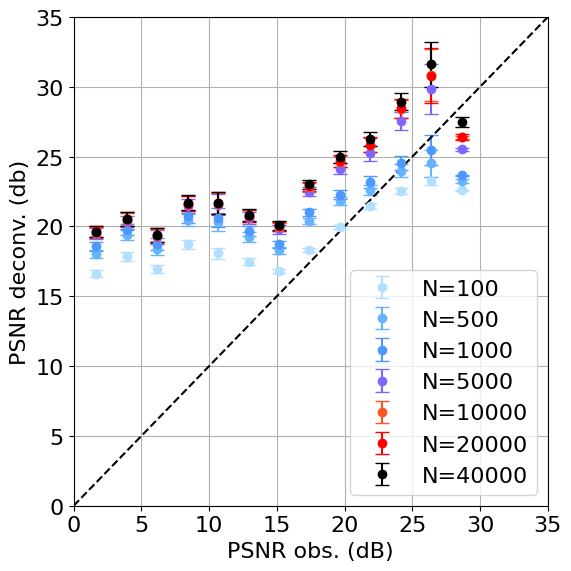

In [56]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
for i,ntrain in enumerate(ntrain_list):

    line = df1.loc[df1["ntrain"] == ntrain]
    psnr_in = line["psnr_in"].iloc[0] 
    psnr_unet = line["psnr_u"].iloc[0] 
    hbprof(psnr_in, psnr_unet, n_bins=15, error_type='sem', ax=ax, label=f'N={ntrain}', 
           color=couleurs_temperature[i])


mynewline = lines.Line2D((0,35),(0,35),
                         color='k',linestyle="--")
ax.add_line(mynewline)
#ax.set_title(f"N train={ntrain}")
ax.grid()
ax.set_xlim([0,35])
ax.set_ylim([0,35]);
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.legend(loc='lower right')#, bbox_to_anchor=(1.5, 1.0))
ax.set_ylabel("PSNR deconv. (db)")
ax.set_xlabel("PSNR obs. (dB)");
plt.tight_layout();
#fig.savefig("psnr_unet_vs_psnr_obs_ntrain.pdf")

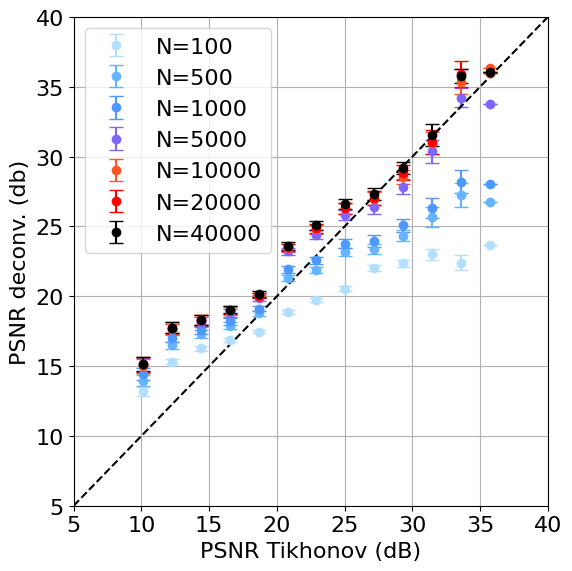

In [57]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
for i,ntrain in enumerate(ntrain_list):

    line = df1.loc[df1["ntrain"] == ntrain]
    psnr_unet = line["psnr_u"].iloc[0] 
    psnr_wiener = line["psnr_w"].iloc[0] 
    hbprof(psnr_wiener, psnr_unet, n_bins=15, error_type='sem', ax=ax, label=f'N={ntrain}', 
           color=couleurs_temperature[i])


mynewline = lines.Line2D((5,40),(5,40),
                         color='k',linestyle="--")
ax.add_line(mynewline)
#ax.set_title(f"N train={ntrain}")
ax.grid()
ax.set_xlim([5,40])
ax.set_ylim([5,40]);
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.legend(loc='upper left')# bbox_to_anchor=(1.5, 1.0))
ax.set_ylabel("PSNR deconv. (db)")
ax.set_xlabel("PSNR Tikhonov (dB)");
plt.tight_layout();
#fig.savefig("psnr_unet_vs_psnr_wiener_ntrain.pdf")

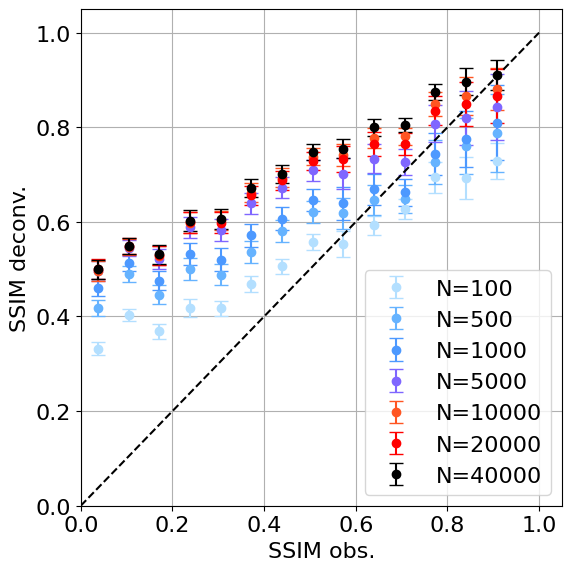

In [58]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
for i,ntrain in enumerate(ntrain_list):

    line = df1.loc[df1["ntrain"] == ntrain]
    ssim_in = line["ssim_in"].iloc[0] 
    ssim_unet = line["ssim_u"].iloc[0] 
    hbprof(ssim_in, ssim_unet, n_bins=15, error_type='sem', ax=ax, label=f'N={ntrain}', 
           color=couleurs_temperature[i])


mynewline = lines.Line2D((0,1),(0,1),
                         color='k',linestyle="--")
ax.add_line(mynewline)
#ax.set_title(f"N train={ntrain}")
ax.grid()
ax.set_xlim([0,1.05])
ax.set_ylim([0,1.05]);
#ax.xaxis.set_major_locator(MultipleLocator(5))
#ax.yaxis.set_major_locator(MultipleLocator(5))
ax.legend(loc='lower right')# bbox_to_anchor=(1.5, 1.0))
ax.set_ylabel("SSIM deconv.")
ax.set_xlabel("SSIM obs.");
plt.tight_layout();
#fig.savefig("ssim_unet_vs_ssim_obs_ntrain.pdf")

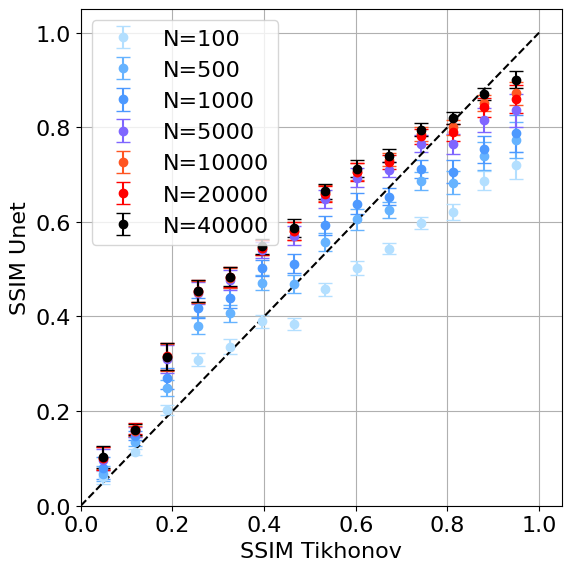

In [59]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
for i,ntrain in enumerate(ntrain_list):

    line = df1.loc[df1["ntrain"] == ntrain]
    ssim_unet = line["ssim_u"].iloc[0] 
    ssim_wiener = line["ssim_w"].iloc[0] 
    hbprof(ssim_wiener, ssim_unet, n_bins=15, error_type='sem', ax=ax, label=f'N={ntrain}', 
           color=couleurs_temperature[i])


mynewline = lines.Line2D((0,1),(0,1),
                         color='k',linestyle="--")
ax.add_line(mynewline)
#ax.set_title(f"N train={ntrain}")
ax.grid()
ax.set_xlim([0,1.05])
ax.set_ylim([0,1.05]);
#ax.xaxis.set_major_locator(MultipleLocator(5))
#ax.yaxis.set_major_locator(MultipleLocator(5))
ax.legend(loc='upper left')#, bbox_to_anchor=(1.5, 1.0))
ax.set_ylabel("SSIM Unet")
ax.set_xlabel("SSIM Tikhonov");
plt.tight_layout();
#fig.savefig("ssim_unet_vs_ssim_wiener_ntrain.pdf")

## Show Unet - Unet_swapped cosine similarity  as fonction wrt Ntrain

In [11]:
ntrain_list = df2["ntrain"].tolist()

In [12]:
ntrain_list

[100, 500, 1000, 5000, 10000, 20000]

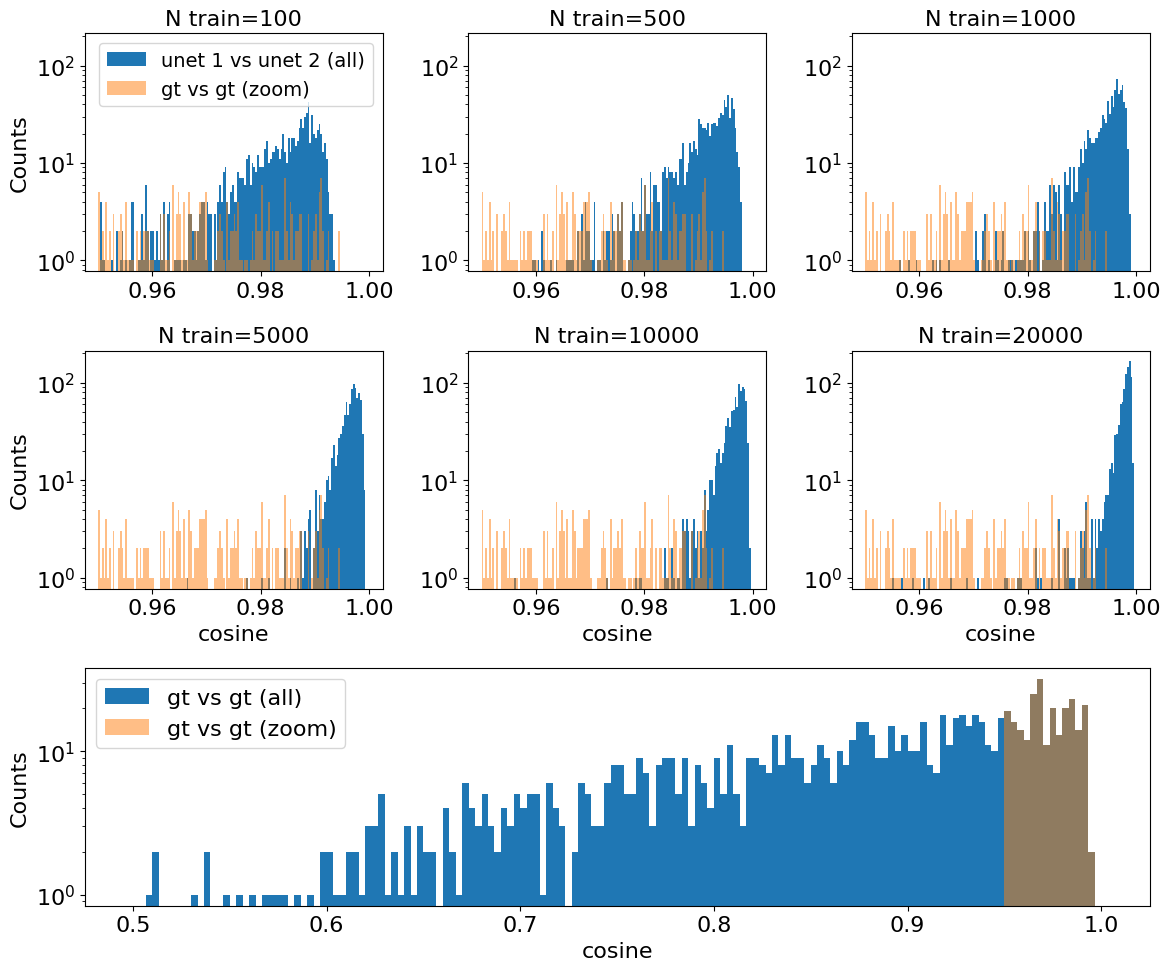

In [14]:
nrows, ncols  = find_best_grid(len(ntrain_list))
fig = plt.figure(figsize=(4*ncols, 4*(nrows + 0.5)))  # Ajuste la hauteur pour la nouvelle ligne
gs = fig.add_gridspec(nrows + 1, ncols)  # +1 pour la ligne supplémentaire

all_axes = []
for idx,ntrain in enumerate(ntrain_list):
    ir, ic  = idx//ncols,idx%ncols
    ax = fig.add_subplot(gs[ir, ic])
    line = df2.loc[df2["ntrain"] == ntrain]
    cos = line["cos"].iloc[0] 
    _,bins,_ = ax.hist(cos, bins=150, range=(0.95,1),label = "unet 1 vs unet 2 (all)")
    #ax.text(0.95,20,fr"$q_{{90}}={np.percentile(cos,10):.4f}$") #90% in [q_90,1] range
    ax.hist(cos_gt_sim,bins=bins,label="gt vs gt (zoom)", alpha=0.5)
    ax.set_title(f"N train={ntrain}")
    all_axes.append(ax)
    ax.set_yscale("log")

all_axes[0].legend(fontsize=14)

ax_gt_0 = fig.add_subplot(gs[nrows,:])
_,bins,_ = ax_gt_0.hist(cos_gt_sim,bins=150,range=(0.5,1),weights=np.ones(len(cos_gt_sim)),label="gt vs gt (all)")
ax_gt_0.hist(cos_gt_sim[cos_gt_sim>0.95],bins=bins,weights=np.ones(len(cos_gt_sim[cos_gt_sim>0.95])), label="gt vs gt (zoom)", alpha=0.5)

#ax_gt_1 = fig.add_subplot(gs[nrows, -1])
#ax_gt_1.hist(cos_gt_sim,bins=50,range=(0.95,1),label="gt vs gt")
ax_gt_0.legend()
ax_gt_0.set_yscale("log")
#ax_gt_1.legend()


ylim = (min(ax.get_ylim()[0] for ax in all_axes), max(ax.get_ylim()[1] for ax in all_axes))
for ax in all_axes:
    ax.set_ylim(ylim)
    


axs = np.array(all_axes).reshape((nrows,ncols))


for ir in range(nrows):
    axs[ir,0].set_ylabel("Counts")
for ic in range(ncols):
    axs[-1,ic].set_xlabel("cosine")

ax_gt_0.set_ylabel("Counts")
ax_gt_0.set_xlabel("cosine")
#ax_gt_1.set_ylabel("Counts")
#ax_gt_1.set_xlabel("cosine")


plt.tight_layout()
plt.show()

#fig.savefig("cosine_sim_2Unets_gtgt.pdf")